In [1433]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping

In [1909]:
t_train=pd.read_csv('t_2_train.csv')
t_train

,SMILES,terminal t1/2 (h),label
0,[Gd+3].COCCNC(=O)CN(CCN(CCN(CC([O-])=O)CC(=O)N...,1.46,0
1,COc1ccc2CN(C)CC[C@@]34C=C[C@H](O)C[C@@H]3Oc1c24,5.30,1
2,C[C@H](\C=C\[C@H](C)C(C)(C)O)[C@H]1CC[C@H]2\C(...,5.30,1
3,c1(n(c2c(C(=O)c3ccccc3C2=O)[n+]1Cc1cnccn1)CCOC)C,24.80,1
4,COC(=O)[C@H](c1ccccc1Cl)N2CCc3c(ccs3)C2,5.06,1
...,...,...,...
1061,CC(C)[C@@H](CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3[C...,9.50,1
1062,CC1=C(C=C(C#N)C(=O)N1)c2ccncc2,0.80,0
1063,c1ccc(cc1)CC[C@H](N[C@@H]1C(N2[C@@H](CCC[N@@]2...,50.60,1
1064,c1cc(ccc1O)[C@@H](CN(C)C)C1(CCCCC1)O,8.40,1


In [1870]:
train_data=pd.read_csv('t_2_train.csv')
train_smiles=list(train_data.iloc[:,0])
train_labels=list(train_data.iloc[:,2])

In [1871]:
test_data=pd.read_csv('t_2_test.csv')
test_smiles=list(test_data.iloc[:,0])
test_labels=list(test_data.iloc[:,2])

In [1872]:
a=[1,2,3]
b=[4,5,6]
c=a+b
c

[1, 2, 3, 4, 5, 6]

In [1873]:
from rdkit.Chem import MACCSkeys
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
def get_finger(smiles):
    all_mols=[]
    for smi in list(smiles):
        m=Chem.MolFromSmiles(smi)
        all_mols.append(m)
    #all_fps=[Chem.RDKFingerprint(mol) for mol in all_mols]
    all_fingerprints1 =[MACCSkeys.GenMACCSKeys(mol).ToBitString() for mol in all_mols]
    all_fingerprints2 =[AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024).ToBitString() for mol in all_mols]
    #all_fingerprints=all_fingerprints1+all_fingerprints2
    #print(all_fingerprints)
    x = []
    for finger in all_fingerprints1:
        x.append(np.fromiter(finger, dtype=int))
    x = np.array(x)
    
    y = []
    for finger in all_fingerprints2:
        y.append(np.fromiter(finger, dtype=int))
    y = np.array(y)
    return x,y

In [1874]:
for smi in list(train_smiles):
        m=Chem.MolFromSmiles(smi)
        try:
            Chem.RDKFingerprint(m) 
        except:
            print(smi)
            print(m)

In [1875]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as ACC
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import f1_score as F1
def auc_roc(y_test1,pre):
    pre=[p for p in pre[:,1]]
    #print(pre)
    fpr,tpr,threshold = roc_curve(y_test1,pre)###计算真正率和假正率
    roc_auc = auc(fpr,tpr)
    #print('roc_auc:%2f'%(roc_auc))
    return roc_auc
def analyze(pre,real):
    AUC_test=auc_roc(real,pre)
    pre=np.argmax(pre,axis=1)
    #print(pre)
    m=confusion_matrix(pre,real, labels=[0,1], sample_weight=None)
    print(m)
    tp, fp, fn, tn = m.ravel()
    TPR=tp/(tp+fn)
    TNR=tn/(tn+fp)
    ACC_test=ACC(real,pre)
    #AUC_test=auc_roc(real,pre)
    MCC_test=MCC(real,pre)
    F1_test=F1(real,pre)
    print('敏感度TPR：%2f，特异度TNR：%2f，ACC：%2f，AUC：%2f,MCC：%2f,F1：%2f'%(TPR,TNR,ACC_test,AUC_test,MCC_test,F1_test))

In [1876]:
x_test1,x_test2=get_finger(test_smiles)

In [1878]:
x_train1,x_train2=get_finger(train_smiles)


In [1879]:
df1 = pd.DataFrame(x_train1)
df2=pd.DataFrame(x_train2)
df=pd.concat([df1,df2],axis=1)
x_train=df.values#as_matrix()
print(x_train)
#df.loc[:, (df != 0).any(axis=0)]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [1880]:
df1 = pd.DataFrame(x_test1)
df2=pd.DataFrame(x_test2)
df=pd.concat([df1,df2],axis=1)
x_test=df.values#as_matrix()
print(x_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [1881]:
#df.to_csv('train_test.csv',index=False)

In [1883]:
x_train.shape

(1066, 1191)

In [1884]:
rf1=RandomForestClassifier(n_jobs=-1,n_estimators=20)#min_samples_leaf=1  ,min_samples_split=2
rf1.fit(x_train,train_labels)

pred_train1=rf1.predict_proba(x_train)
analyze(pred_train1,train_labels)

pred_test1=rf1.predict_proba(x_test)
analyze(pred_test1,test_labels)


[[431   4]
 [  1 630]]
敏感度TPR：0.997685，特异度TNR：0.993691，ACC：0.995310，AUC：0.999923,MCC：0.990297,F1：0.996047
[[ 67  48]
 [ 41 110]]
敏感度TPR：0.620370，特异度TNR：0.696203，ACC：0.665414，AUC：0.729518,MCC：0.313817,F1：0.711974


In [1866]:
num_samples=x_train.shape[0]//5


In [1867]:
print(num_samples)

213


In [1886]:
i=0
rf0=RandomForestClassifier( n_estimators=31,max_depth=3)#min_samples_leaf=6, , max_depth=12, min_samples_split=10,max_features=25 )#, min_samples_split=5,  
                                # min_samples_leaf=6,max_features=25 , random_state=10)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
rf0.fit(train_data,train_label)
pre_rf=rf0.predict_proba(val_data)
aa0=analyze(pre_rf,val_label)
#pre_rf=rf0.predict_proba(train_data)
#analyze(pre_rf,train_label)
i=1
rf1=RandomForestClassifier( n_estimators=31,max_depth=3)#(min_samples_leaf=6, n_estimators=31)#, max_depth=12, min_samples_split=10,max_features=25 )#, min_samples_split=5,  
                                 #min_samples_leaf=6,max_features=25 ,oob_score=True, random_state=10)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
rf1.fit(train_data,train_label)
pre_rf=rf1.predict_proba(val_data)
acc1=analyze(pre_rf,val_label)
#pre_rf=rf1.predict_proba(train_data)
#analyze(pre_rf,train_label)
i=2
rf2=RandomForestClassifier( n_estimators=31,max_depth=3)#(min_samples_leaf=6, n_estimators=31)# max_depth=12, min_samples_split=10,max_features=25 )#, min_samples_split=5,  
                                # min_samples_leaf=6,max_features=25 ,oob_score=True, random_state=10)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
rf2.fit(train_data,train_label)
pre_rf=rf2.predict_proba(val_data)
acc2=analyze(pre_rf,val_label)
#pre_rf=rf2.predict_proba(train_data)
#analyze(pre_rf,train_label)
i=3
rf3=RandomForestClassifier( n_estimators=31,max_depth=3)#(min_samples_leaf=6, n_estimators=31)# max_depth=12, min_samples_split=10,max_features=25 )#, min_samples_split=5,  
                                # min_samples_leaf=6,max_features=25 ,oob_score=True, random_state=10)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
rf3.fit(train_data,train_label)
pre_rf=rf3.predict_proba(val_data)
acc3=analyze(pre_rf,val_label)
#pre_rf=rf3.predict_proba(train_data)
#analyze(pre_rf,train_label)
i=4
rf4=RandomForestClassifier( n_estimators=31,max_depth=3)#(min_samples_leaf=6, n_estimators=31)#max_depth=12,min_samples_split=10,max_features=25 )#, min_samples_split=5,  
                                 #min_samples_leaf=6,max_features=25 ,oob_score=True, random_state=10)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
rf4.fit(train_data,train_label)
pre_rf=rf4.predict_proba(val_data)
acc4=analyze(pre_rf,val_label)
#pre_rf=rf4.predict_proba(train_data)
#analyze(pre_rf,train_label)
print('test')
probarf0=rf0.predict_proba(x_test)
probarf1=rf1.predict_proba(x_test)
probarf2=rf2.predict_proba(x_test)
probarf3=rf3.predict_proba(x_test)
probarf4=rf4.predict_proba(x_test)
probarf_test=(probarf0+probarf1+probarf2+probarf3+probarf4)/5.0
#probarf=(probarf1+probarf2+probarf3+probarf4)/5.0
aa=analyze(probarf_test,test_labels)

[[ 11   1]
 [ 68 133]]
敏感度TPR：0.139241，特异度TNR：0.992537，ACC：0.676056，AUC：0.698375,MCC：0.276070,F1：0.794030
[[ 16   2]
 [ 80 115]]
敏感度TPR：0.166667，特异度TNR：0.982906，ACC：0.615023，AUC：0.717325,MCC：0.267564,F1：0.737179
[[ 14   5]
 [ 60 134]]
敏感度TPR：0.189189，特异度TNR：0.964029，ACC：0.694836，AUC：0.676940,MCC：0.255950,F1：0.804805
[[ 13   2]
 [ 80 118]]
敏感度TPR：0.139785，特异度TNR：0.983333，ACC：0.615023，AUC：0.678136,MCC：0.238658,F1：0.742138
[[ 19   4]
 [ 71 119]]
敏感度TPR：0.211111，特异度TNR：0.967480，ACC：0.647887，AUC：0.722222,MCC：0.284245,F1：0.760383
test
[[ 19   7]
 [ 89 151]]
敏感度TPR：0.175926，特异度TNR：0.955696，ACC：0.639098，AUC：0.752696,MCC：0.217659,F1：0.758794


In [1932]:
i=0
rf0=RandomForestClassifier(n_estimators=20)#,max_depth=20,max_features=8)#min_samples_leaf=6, , max_depth=12, min_samples_split=10,max_features=25 )#, min_samples_split=5,  
                                # min_samples_leaf=6,max_features=25 , random_state=10)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
rf0.fit(train_data,train_label)
pre_rf_train1=rf1.predict_proba(train_data)
acc1=analyze(pre_rf_train1,train_label)
pre_rf=rf0.predict_proba(val_data)
aa0=analyze(pre_rf,val_label)
print('test0')
probarf0=rf0.predict_proba(x_test)
analyze(probarf0,test_labels)

[[243  25]
 [110 475]]
敏感度TPR：0.688385，特异度TNR：0.950000，ACC：0.841735，AUC：0.944547,MCC：0.677345,F1：0.875576
[[ 39  30]
 [ 40 104]]
敏感度TPR：0.493671，特异度TNR：0.776119，ACC：0.671362，AUC：0.727943,MCC：0.278475,F1：0.748201
test0
[[ 61  38]
 [ 47 120]]
敏感度TPR：0.564815，特异度TNR：0.759494，ACC：0.680451，AUC：0.731188,MCC：0.329475,F1：0.738462


In [1933]:
traindata00=t_train.iloc[:i*num_samples,:]
traindata01=t_train.iloc[(i+1)*num_samples:,:]
traindata0=pd.concat([traindata00,traindata01],axis=0)
traindata0

,SMILES,terminal t1/2 (h),label
213,[Gd+3].OC(=O)CN(CCN(CCN(CC(O)=O)CC([O-])=O)CC(...,1.60,0
214,Cc1cc(C)c2N(C[C@@H]3CC[C@H](CC3)C(=O)O)CCC[C@H...,51.94,1
215,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,97.00,1
216,CNC(=O)c1ccccc1Sc2ccc3c(c2)[nH]nc3/C=C/c4ccccn4,4.30,1
217,C(C(C)C)CCCCCCC(=O)N[C@H]1[C@H](Oc2c3cc4[C@H](...,66.80,1
...,...,...,...
1061,CC(C)[C@@H](CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3[C...,9.50,1
1062,CC1=C(C=C(C#N)C(=O)N1)c2ccncc2,0.80,0
1063,c1ccc(cc1)CC[C@H](N[C@@H]1C(N2[C@@H](CCC[N@@]2...,50.60,1
1064,c1cc(ccc1O)[C@@H](CN(C)C)C1(CCCCC1)O,8.40,1


In [1934]:
pres=np.argmax(pre_rf_train1,axis=1)
m=0
index=[]
df_all0=pd.DataFrame()
for i in range(len(pres)):
    if pres[i]!=traindata0.iloc[i,2]:
        index.append(i)
        #df=traindata0.iloc[i,:]
        #print(df)
        #df_all0=pd.concat([df_all0,df],axis=0)
        #print(pres[i],traindata0.iloc[i,2])
        m+=1
df_all0=traindata0.iloc[index,:]
print(m)
df_all0

135


,SMILES,terminal t1/2 (h),label
221,CCCC(=O)OCOC(=O)C1=C(C)NC(=C(C1c2cccc(Cl)c2Cl)...,0.30,0
224,Cc1nnc2CN=C(c3ccccc3Cl)c4cc(Cl)ccc4n12,2.70,0
236,CO[C@H]1C[C@H](C)CC2=C(NCC=C)C(=O)C=C(NC(=O)\C...,3.00,1
237,C(c1ccc(cc1)OC[C@@H](C[N@@](CCC[S@@](=O)CCC)CC...,2.40,0
259,COc1ccccc1OCCNCC(O)COc2cccc3[nH]c4ccccc4c23,2.40,0
...,...,...,...
1054,NCCCC[C@H](NC(=O)[C@@H](Cc1cc(Br)c(O)c(Br)c1)N...,2.50,0
1055,O=N(=O)O[C@H]1CO[C@@H]2[C@@H](CO[C@H]12)ON(=O)=O,1.70,0
1057,CC([N@+]1([C@@H]2C[C@@H](C[C@@H]1CC2)OC(=O)[C@...,3.30,1
1058,O[C@H](/C=C/[C@@H]1N(CCSCCCC(O)=O)C(CC1)=O)CC2...,0.38,0


In [1892]:
## i=1
rf1=RandomForestClassifier(n_estimators=10,max_depth=20,max_features=8,min_samples_leaf=2)#,max_depth=20,max_features=8)#(min_samples_leaf=6, n_estimators=31)#, max_depth=12, min_samples_split=10,max_features=25 )#, min_samples_split=5,  
                                 #min_samples_leaf=6,max_features=25 ,oob_score=True, random_state=10)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
rf1.fit(train_data,train_label)
pre_rf_train2=rf1.predict_proba(train_data)
acc1=analyze(pre_rf_train2,train_label)
pre_rf=rf1.predict_proba(val_data)
acc1=analyze(pre_rf,val_label)
print('test1')
probarf1=rf1.predict_proba(x_test)
analyze(probarf1,test_labels)

[[243  25]
 [110 475]]
敏感度TPR：0.688385，特异度TNR：0.950000，ACC：0.841735，AUC：0.944547,MCC：0.677345,F1：0.875576
[[ 30  16]
 [ 49 118]]
敏感度TPR：0.379747，特异度TNR：0.880597，ACC：0.694836，AUC：0.686945,MCC：0.305616,F1：0.784053
test1
[[ 42  28]
 [ 66 130]]
敏感度TPR：0.388889，特异度TNR：0.822785，ACC：0.646617，AUC：0.677801,MCC：0.236064,F1：0.734463


In [1894]:
i=2
rf2=RandomForestClassifier(n_estimators=20)#,max_depth=20,max_features=8)#(min_samples_leaf=6, n_estimators=31)# max_depth=12, min_samples_split=10,max_features=25 )#, min_samples_split=5,  
                                # min_samples_leaf=6,max_features=25 ,oob_score=True, random_state=10)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
rf2.fit(train_data,train_label)
pre_rf=rf1.predict_proba(train_data)
acc1=analyze(pre_rf,train_label)
pre_rf=rf2.predict_proba(val_data)
acc2=analyze(pre_rf,val_label)
print('test2')
probarf2=rf2.predict_proba(x_test)
analyze(probarf2,test_labels)

[[220  34]
 [138 461]]
敏感度TPR：0.614525，特异度TNR：0.931313，ACC：0.798359，AUC：0.895424,MCC：0.589085,F1：0.842779
[[ 43  37]
 [ 31 102]]
敏感度TPR：0.581081，特异度TNR：0.733813，ACC：0.680751，AUC：0.743340,MCC：0.309611,F1：0.750000
test2
[[ 69  44]
 [ 39 114]]
敏感度TPR：0.638889，特异度TNR：0.721519，ACC：0.687970，AUC：0.732859,MCC：0.358055,F1：0.733119


In [1897]:
i=3
rf3=RandomForestClassifier(n_estimators=20)#,max_depth=20,max_features=8)#(min_samples_leaf=6, n_estimators=31)# max_depth=12, min_samples_split=10,max_features=25 )#, min_samples_split=5,  
                                # min_samples_leaf=6,max_features=25 ,oob_score=True, random_state=10)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
rf3.fit(train_data,train_label)
pre_rf=rf1.predict_proba(train_data)
acc1=analyze(pre_rf,train_label)
pre_rf=rf3.predict_proba(val_data)
acc3=analyze(pre_rf,val_label)
print('test3')
probarf3=rf3.predict_proba(x_test)
analyze(probarf3,test_labels)

[[212  34]
 [127 480]]
敏感度TPR：0.625369，特异度TNR：0.933852，ACC：0.811254，AUC：0.889401,MCC：0.604092,F1：0.856378
[[ 43  20]
 [ 50 100]]
敏感度TPR：0.462366，特异度TNR：0.833333，ACC：0.671362，AUC：0.754256,MCC：0.321341,F1：0.740741
test3
[[ 61  38]
 [ 47 120]]
敏感度TPR：0.564815，特异度TNR：0.759494，ACC：0.680451，AUC：0.751377,MCC：0.329475,F1：0.738462


In [1899]:
i=4
rf4=RandomForestClassifier(n_estimators=20)#,max_depth=20,max_features=8)#(min_samples_leaf=6, n_estimators=31)#max_depth=12,min_samples_split=10,max_features=25 )#, min_samples_split=5,  
                                 #min_samples_leaf=6,max_features=25 ,oob_score=True, random_state=10)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
rf4.fit(train_data,train_label)
pre_rf=rf1.predict_proba(train_data)
acc1=analyze(pre_rf,train_label)
pre_rf=rf4.predict_proba(val_data)
acc4=analyze(pre_rf,val_label)
print('test4')
probarf4=rf4.predict_proba(x_test)
analyze(probarf4,test_labels)

[[213  34]
 [129 477]]
敏感度TPR：0.622807，特异度TNR：0.933464，ACC：0.808910，AUC：0.891761,MCC：0.601070,F1：0.854073
[[44 27]
 [46 96]]
敏感度TPR：0.488889，特异度TNR：0.780488，ACC：0.657277，AUC：0.726423,MCC：0.282267,F1：0.724528
test4
[[ 57  40]
 [ 51 118]]
敏感度TPR：0.527778，特异度TNR：0.746835，ACC：0.657895，AUC：0.744462,MCC：0.280177,F1：0.721713


In [1611]:
analyze(probarf0,test_labels)
analyze(probarf1,test_labels)
analyze(probarf2,test_labels)
analyze(probarf3,test_labels)
analyze(probarf4,test_labels)


print('test_all')
probarf_test=(probarf0+probarf1+probarf2+probarf3+probarf4)/5.0
#probarf=(probarf1+probarf2+probarf3+probarf4)/5.0
aa=analyze(probarf_test,test_labels)

[[ 57  50]
 [ 51 108]]
敏感度TPR：0.527778，特异度TNR：0.683544，ACC：0.620301，AUC：0.681991,MCC：0.211639,F1：0.681388
[[ 64  41]
 [ 44 117]]
敏感度TPR：0.592593，特异度TNR：0.740506，ACC：0.680451，AUC：0.709271,MCC：0.334662,F1：0.733542
[[ 62  39]
 [ 46 119]]
敏感度TPR：0.574074，特异度TNR：0.753165，ACC：0.680451，AUC：0.741063,MCC：0.331133,F1：0.736842
[[ 56  38]
 [ 52 120]]
敏感度TPR：0.518519，特异度TNR：0.759494，ACC：0.661654，AUC：0.724713,MCC：0.285612,F1：0.727273
[[ 61  34]
 [ 47 124]]
敏感度TPR：0.564815，特异度TNR：0.784810，ACC：0.695489，AUC：0.733122,MCC：0.358330,F1：0.753799
test_all
[[ 56  34]
 [ 52 124]]
敏感度TPR：0.518519，特异度TNR：0.784810，ACC：0.676692，AUC：0.743905,MCC：0.314830,F1：0.742515


In [1431]:
import pickle
def save_model(name,model):
    model_name=name+'.pkl'
    with open(model_name, 'ab') as f:
        pickle.dump(model, f)
# save_model('t_2_rf02',rf0)
# save_model('t_2_rf12',rf1)
# save_model('t_2_rf22',rf2)
# save_model('t_2_rf32',rf3)
# save_model('t_2_rf42',rf4)

In [1218]:
xg=XGBClassifier(n_estimators=200,max_depth=12,learning_rate=0.06)
xg.fit(x_train,train_labels)
pre_xg=xg.predict_proba(x_test)
analyze(pre_xg,test_labels)

[[ 68  45]
 [ 40 113]]
敏感度TPR：0.629630，特异度TNR：0.715190，ACC：0.680451，AUC：0.747539,MCC：0.342568,F1：0.726688


In [1213]:
xg=XGBClassifier(n_estimators=200,max_depth=12,learning_rate=0.050)
xg.fit(x_train,train_labels)
pre_xg=xg.predict_proba(x_test)
analyze(pre_xg,test_labels)

[[ 69  40]
 [ 39 118]]
敏感度TPR：0.638889，特异度TNR：0.746835，ACC：0.703008，AUC：0.754864,MCC：0.385172,F1：0.749206


In [1612]:
i=0
xg0=XGBClassifier(n_estimators=200,max_depth=12,learning_rate=0.050)#,max_depth=5)#n_estimators=210)#,max_depth=7,learning_rate=0.105)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
xg0.fit(train_data,train_label)
pre_xg=xg0.predict_proba(val_data)
analyze(pre_xg,val_label)
print('test')
pre_xg0=xg0.predict_proba(x_test)
analyze(pre_xg0,test_labels)

[[ 43  23]
 [ 36 111]]
敏感度TPR：0.544304，特异度TNR：0.828358，ACC：0.723005，AUC：0.770829,MCC：0.389270,F1：0.790036
test
[[ 67  43]
 [ 41 115]]
敏感度TPR：0.620370，特异度TNR：0.727848，ACC：0.684211，AUC：0.720816,MCC：0.347243,F1：0.732484


In [1733]:
i=1
xg1=XGBClassifier(n_estimators=200,max_depth=12,learning_rate=0.050)#,max_depth=5)#n_estimators=210)#,max_depth=7,learning_rate=0.105)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
xg1.fit(train_data,train_label)
pre_xg=xg1.predict_proba(val_data)
analyze(pre_xg,val_label)
print('test')
pre_xg1=xg1.predict_proba(x_test)
analyze(pre_xg1,test_labels)

[[60 23]
 [36 94]]
敏感度TPR：0.625000，特异度TNR：0.803419，ACC：0.723005，AUC：0.744035,MCC：0.437106,F1：0.761134
test
[[ 64  37]
 [ 44 121]]
敏感度TPR：0.592593，特异度TNR：0.765823，ACC：0.695489，AUC：0.748183,MCC：0.362681,F1：0.749226


In [1615]:
i=2
xg2=XGBClassifier(n_estimators=200,max_depth=12,learning_rate=0.050)#,max_depth=5)#n_estimators=210)#,max_depth=7,learning_rate=0.105)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
xg2.fit(train_data,train_label)
pre_xg=xg2.predict_proba(val_data)
analyze(pre_xg,val_label)
print('test')
pre_xg2=xg2.predict_proba(x_test)
analyze(pre_xg2,test_labels)

[[ 43  30]
 [ 31 109]]
敏感度TPR：0.581081，特异度TNR：0.784173，ACC：0.713615，AUC：0.779312,MCC：0.366431,F1：0.781362
test
[[ 65  50]
 [ 43 108]]
敏感度TPR：0.601852，特异度TNR：0.683544，ACC：0.650376，AUC：0.728200,MCC：0.282912,F1：0.699029


In [1616]:
i=3
xg3=XGBClassifier(n_estimators=200,max_depth=12,learning_rate=0.050)#,max_depth=5)#n_estimators=210)#,max_depth=7,learning_rate=0.105)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
xg3.fit(train_data,train_label)
pre_xg=xg3.predict_proba(val_data)
analyze(pre_xg,val_label)
print('test')
pre_xg3=xg3.predict_proba(x_test)
analyze(pre_xg3,test_labels)

[[ 42  20]
 [ 51 100]]
敏感度TPR：0.451613，特异度TNR：0.833333，ACC：0.666667，AUC：0.777957,MCC：0.311108,F1：0.738007
test
[[ 59  34]
 [ 49 124]]
敏感度TPR：0.546296，特异度TNR：0.784810，ACC：0.687970，AUC：0.749531,MCC：0.340991,F1：0.749245


In [1617]:
i=4
xg4=XGBClassifier(n_estimators=200,max_depth=12,learning_rate=0.050)#,max_depth=5)#n_estimators=210)#,max_depth=7,learning_rate=0.105)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
xg4.fit(train_data,train_label)
pre_xg=xg4.predict_proba(val_data)
analyze(pre_xg,val_label)
print('test')
pre_xg4=xg4.predict_proba(x_test)
analyze(pre_xg4,test_labels)

[[51 27]
 [39 96]]
敏感度TPR：0.566667，特异度TNR：0.780488，ACC：0.690141，AUC：0.746612,MCC：0.355945,F1：0.744186
test
[[ 63  39]
 [ 45 119]]
敏感度TPR：0.583333，特异度TNR：0.753165，ACC：0.684211，AUC：0.752286,MCC：0.339861,F1：0.739130


In [1258]:
gbm = GradientBoostingClassifier(n_estimators=70)
gbm.fit(x_train,train_labels)
pre_gbm=gbm.predict_proba(x_test)
analyze(pre_gbm,test_labels)

[[ 59  33]
 [ 49 125]]
敏感度TPR：0.546296，特异度TNR：0.791139，ACC：0.691729，AUC：0.764299,MCC：0.348388,F1：0.753012


In [1746]:
i=0
gbm0=GradientBoostingClassifier(n_estimators=70)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
gbm0.fit(train_data,train_label)
pre_xg=gbm0.predict_proba(val_data)
analyze(pre_xg,val_label)
print('test')
pre_gbm0=gbm0.predict_proba(x_test)
analyze(pre_gbm0,test_labels)

[[ 38  22]
 [ 41 112]]
敏感度TPR：0.481013，特异度TNR：0.835821，ACC：0.704225，AUC：0.718307,MCC：0.340232,F1：0.780488
test
[[ 62  36]
 [ 46 122]]
敏感度TPR：0.574074，特异度TNR：0.772152，ACC：0.691729，AUC：0.740741,MCC：0.352478,F1：0.748466


In [1619]:
i=1
gbm1=GradientBoostingClassifier(n_estimators=70)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
gbm1.fit(train_data,train_label)
pre_xg=gbm1.predict_proba(val_data)
analyze(pre_xg,val_label)
print('test')
pre_gbm1=gbm1.predict_proba(x_test)
analyze(pre_gbm1,test_labels)

[[44 23]
 [52 94]]
敏感度TPR：0.458333，特异度TNR：0.803419，ACC：0.647887，AUC：0.688925,MCC：0.280482,F1：0.714829
test
[[ 54  32]
 [ 54 126]]
敏感度TPR：0.500000，特异度TNR：0.797468，ACC：0.676692，AUC：0.740038,MCC：0.312317,F1：0.745562


In [1743]:
i=2
gbm2=GradientBoostingClassifier(n_estimators=70)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
gbm2.fit(train_data,train_label)
pre_xg=gbm2.predict_proba(val_data)
analyze(pre_xg,val_label)
print('test')
pre_gbm2=gbm2.predict_proba(x_test)
analyze(pre_gbm2,test_labels)

[[ 35  24]
 [ 39 115]]
敏感度TPR：0.472973，特异度TNR：0.827338，ACC：0.704225，AUC：0.722001,MCC：0.319528,F1：0.784983
test
[[ 61  40]
 [ 47 118]]
敏感度TPR：0.564815，特异度TNR：0.746835，ACC：0.672932，AUC：0.744814,MCC：0.315359,F1：0.730650


In [1621]:
i=3
gbm3=GradientBoostingClassifier(n_estimators=70)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
gbm3.fit(train_data,train_label)
pre_xg=gbm3.predict_proba(val_data)
analyze(pre_xg,val_label)
print('test')
pre_gbm3=gbm3.predict_proba(x_test)
analyze(pre_gbm3,test_labels)

[[ 32  13]
 [ 61 107]]
敏感度TPR：0.344086，特异度TNR：0.891667，ACC：0.652582，AUC：0.732348,MCC：0.286436,F1：0.743056
test
[[ 49  31]
 [ 59 127]]
敏感度TPR：0.453704，特异度TNR：0.803797，ACC：0.661654，AUC：0.729723,MCC：0.275752,F1：0.738372


In [1622]:
i=4
gbm4=GradientBoostingClassifier(n_estimators=70)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
gbm4.fit(train_data,train_label)
pre_xg=gbm4.predict_proba(val_data)
analyze(pre_xg,val_label)
print('test')
pre_gbm4=gbm4.predict_proba(x_test)
analyze(pre_gbm4,test_labels)

[[ 34  20]
 [ 56 103]]
敏感度TPR：0.377778，特异度TNR：0.837398，ACC：0.643192，AUC：0.743541,MCC：0.244328,F1：0.730496
test
[[ 54  28]
 [ 54 130]]
敏感度TPR：0.500000，特异度TNR：0.822785，ACC：0.691729，AUC：0.767727,MCC：0.343271,F1：0.760234


In [1353]:
clf = SVC(probability=True,C=3,gamma=0.0015)#,gamma=0.00005,kernel='rbf',)
clf.fit(x_train,train_labels)
pre_clf=clf.predict_proba(x_test)
analyze(pre_clf,test_labels)

[[ 59  32]
 [ 49 126]]
敏感度TPR：0.546296，特异度TNR：0.797468，ACC：0.695489，AUC：0.756388,MCC：0.355846,F1：0.756757


In [1635]:
i=0
clf0 = SVC(probability=True,C=3,gamma=0.0015)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
clf0.fit(train_data,train_label)
pre_clf=clf0.predict_proba(val_data)
analyze(pre_clf,val_label)
print('test')
pre_clf0=clf0.predict_proba(x_test)
analyze(pre_clf0,test_labels)

[[ 38  20]
 [ 41 114]]
敏感度TPR：0.481013，特异度TNR：0.850746，ACC：0.713615，AUC：0.743151,MCC：0.360005,F1：0.788927
test
[[ 57  33]
 [ 51 125]]
敏感度TPR：0.527778，特异度TNR：0.791139，ACC：0.684211，AUC：0.748183,MCC：0.331010,F1：0.748503


In [1629]:
i=1
clf1 = SVC(probability=True,C=3,gamma=0.0015)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
clf1.fit(train_data,train_label)
pre_clf=clf1.predict_proba(val_data)
analyze(pre_clf,val_label)
print('test')
pre_clf1=clf1.predict_proba(x_test)
analyze(pre_clf1,test_labels)

[[49 26]
 [47 91]]
敏感度TPR：0.510417，特异度TNR：0.777778，ACC：0.657277，AUC：0.703526,MCC：0.300223,F1：0.713725
test
[[ 58  32]
 [ 50 126]]
敏感度TPR：0.537037，特异度TNR：0.797468，ACC：0.691729，AUC：0.753047,MCC：0.347189,F1：0.754491


In [1630]:
i=2
clf2 = SVC(probability=True,C=3,gamma=0.0015)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
clf2.fit(train_data,train_label)
pre_clf=clf2.predict_proba(val_data)
analyze(pre_clf,val_label)
print('test')
pre_clf2=clf2.predict_proba(x_test)
analyze(pre_clf2,test_labels)

[[ 40  30]
 [ 34 109]]
敏感度TPR：0.540541，特异度TNR：0.784173，ACC：0.699531，AUC：0.767256,MCC：0.329159,F1：0.773050
test
[[ 61  35]
 [ 47 123]]
敏感度TPR：0.564815，特异度TNR：0.778481，ACC：0.691729，AUC：0.756271,MCC：0.351034,F1：0.750000


In [1638]:
i=3
clf3 = SVC(probability=True,C=3,gamma=0.0015)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
clf3.fit(train_data,train_label)
pre_clf=clf3.predict_proba(val_data)
analyze(pre_clf,val_label)
print('test')
pre_clf3=clf3.predict_proba(x_test)
analyze(pre_clf3,test_labels)

[[ 38  18]
 [ 55 102]]
敏感度TPR：0.408602，特异度TNR：0.850000，ACC：0.657277，AUC：0.705869,MCC：0.291354,F1：0.736462
test
[[ 54  30]
 [ 54 128]]
敏感度TPR：0.500000，特异度TNR：0.810127，ACC：0.684211，AUC：0.740038,MCC：0.327645,F1：0.752941


In [1637]:
i=4
clf4 = SVC(probability=True,C=3,gamma=0.0015)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
clf4.fit(train_data,train_label)
pre_clf=clf4.predict_proba(val_data)
analyze(pre_clf,val_label)
print('test')
pre_clf4=clf4.predict_proba(x_test)
analyze(pre_clf4,test_labels)

[[51 27]
 [39 96]]
敏感度TPR：0.566667，特异度TNR：0.780488，ACC：0.690141，AUC：0.742276,MCC：0.355945,F1：0.744186
test
[[ 61  34]
 [ 47 124]]
敏感度TPR：0.564815，特异度TNR：0.784810，ACC：0.695489，AUC：0.772797,MCC：0.358330,F1：0.753799


In [ ]:
gbm = GradientBoostingClassifier(n_estimators=70)
gbm.fit(x_train,train_labels)
pre_gbm=gbm.predict_proba(x_test)
analyze(pre_gbm,test_labels)

In [1486]:
from sklearn.tree import DecisionTreeClassifier

In [1539]:
model = DecisionTreeClassifier(max_depth=5,criterion = 'gini',min_samples_split = 20)
model.fit(x_train,train_labels)
pre_cart = model.predict_proba(x_test)
analyze(pre_cart,test_labels)

[[ 55  32]
 [ 53 126]]
敏感度TPR：0.509259，特异度TNR：0.797468，ACC：0.680451，AUC：0.679970,MCC：0.321075,F1：0.747774


In [1640]:
i=0
cart0 = DecisionTreeClassifier(max_depth=5,criterion = 'gini',min_samples_split = 20)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
cart0.fit(train_data,train_label)
pre_clf=cart0.predict_proba(val_data)
analyze(pre_clf,val_label)
print('test')
pre_cart0=cart0.predict_proba(x_test)
analyze(pre_cart0,test_labels)

[[ 36  28]
 [ 43 106]]
敏感度TPR：0.455696，特异度TNR：0.791045，ACC：0.666667，AUC：0.662054,MCC：0.259971,F1：0.749117
test
[[ 54  39]
 [ 54 119]]
敏感度TPR：0.500000，特异度TNR：0.753165，ACC：0.650376，AUC：0.637482,MCC：0.260723,F1：0.719033


In [1642]:
i=1
cart1 = DecisionTreeClassifier(max_depth=5,criterion = 'gini',min_samples_split = 20)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
cart1.fit(train_data,train_label)
pre_clf=cart1.predict_proba(val_data)
analyze(pre_clf,val_label)
print('test')
pre_cart1=cart1.predict_proba(x_test)
analyze(pre_cart1,test_labels)

[[38 24]
 [58 93]]
敏感度TPR：0.395833，特异度TNR：0.794872，ACC：0.615023，AUC：0.656962,MCC：0.208885,F1：0.694030
test
[[ 46  31]
 [ 62 127]]
敏感度TPR：0.425926，特异度TNR：0.803797，ACC：0.650376，AUC：0.674197,MCC：0.248754,F1：0.731988


In [1646]:
i=2
cart2 = DecisionTreeClassifier(max_depth=5,criterion = 'gini',min_samples_split = 20)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
cart2.fit(train_data,train_label)
pre_clf=cart2.predict_proba(val_data)
analyze(pre_clf,val_label)
print('test')
pre_cart2=cart2.predict_proba(x_test)
analyze(pre_cart2,test_labels)

[[ 32  22]
 [ 42 117]]
敏感度TPR：0.432432，特异度TNR：0.841727，ACC：0.699531，AUC：0.692397,MCC：0.300075,F1：0.785235
test
[[ 50  33]
 [ 58 125]]
敏感度TPR：0.462963，特异度TNR：0.791139，ACC：0.657895，AUC：0.654448,MCC：0.269330,F1：0.733138


In [1680]:
i=3
cart3 = DecisionTreeClassifier(max_depth=5,criterion = 'gini',min_samples_split = 10)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
cart3.fit(train_data,train_label)
pre_clf=cart3.predict_proba(val_data)
analyze(pre_clf,val_label)
print('test')
pre_cart3=cart3.predict_proba(x_test)
analyze(pre_cart3,test_labels)

[[ 44  20]
 [ 49 100]]
敏感度TPR：0.473118，特异度TNR：0.833333，ACC：0.676056，AUC：0.663441,MCC：0.331521,F1：0.743494
test
[[ 55  31]
 [ 53 127]]
敏感度TPR：0.509259，特异度TNR：0.803797，ACC：0.684211，AUC：0.712318,MCC：0.328684,F1：0.751479


In [1647]:
i=4
cart4 = DecisionTreeClassifier(max_depth=5,criterion = 'gini',min_samples_split = 20)
val_data= x_train[i*num_samples:(i+1)*num_samples,:]
val_label= train_labels[i * num_samples:(i + 1) * num_samples]
train_data=np.concatenate([x_train[:i*num_samples,:],x_train[(i+1)*num_samples:,:]],axis=0)
train_label = np.concatenate([train_labels[:i*num_samples], train_labels[(i + 1) * num_samples:]], axis=0)
cart4.fit(train_data,train_label)
pre_clf=cart4.predict_proba(val_data)
analyze(pre_clf,val_label)
print('test')
pre_cart4=cart4.predict_proba(x_test)
analyze(pre_cart4,test_labels)

[[40 28]
 [50 95]]
敏感度TPR：0.444444，特异度TNR：0.772358，ACC：0.633803，AUC：0.624345,MCC：0.229720,F1：0.708955
test
[[ 52  35]
 [ 56 123]]
敏感度TPR：0.481481，特异度TNR：0.778481，ACC：0.657895，AUC：0.662037,MCC：0.272123,F1：0.729970


In [1777]:
rf_4=np.argmax(probarf4,axis=1)
clf_2=np.argmax(pre_clf2,axis=1)
xg_1=np.argmax(pre_xg1,axis=1)
gbm_0=np.argmax(pre_gbm0,axis=1)
cart_3=np.argmax(pre_cart3,axis=1)



In [1778]:
pre=[]
for i in range(len(test_labels)):
    p=[rf_4[i],clf_2[i],xg_1[i],gbm_0[i],cart_3[i]]
    #print(p)
    #print(test_labels[i])
    n_0=np.count_nonzero(p)
    #rint(n_0)
    if n_0<3:
        pre.append(0)
    else:
        pre.append(1)
m=confusion_matrix(pre,test_labels, labels=[0,1], sample_weight=None)
print(m)
ACC_test=ACC(pre,test_labels)
print(ACC_test)

[[ 60  31]
 [ 48 127]]
0.7030075187969925


In [1779]:
print('test_all')
probarf_test=(probarf4+pre_clf2+pre_xg1+pre_gbm0+pre_cart3)/5.0
#probarf=(probarf1+probarf2+probarf3+probarf4)/5.0
aa=analyze(probarf_test,test_labels)

test_all
[[ 53  31]
 [ 55 127]]
敏感度TPR：0.490741，特异度TNR：0.803797，ACC：0.676692，AUC：0.778833,MCC：0.311176,F1：0.747059


In [1429]:
print('test_all')
probarf_test=(probarf0*1+pre_clf2+pre_xg1*1+pre_gbm4*1)/5.0
#probarf=(probarf1+probarf2+probarf3+probarf4)/5.0
aa=analyze(probarf_test,test_labels)

test_all
[[ 61  34]
 [ 47 124]]
敏感度TPR：0.564815，特异度TNR：0.784810，ACC：0.695489，AUC：0.772855,MCC：0.358330,F1：0.753799


In [1399]:
print('test_all')
probarf_test=(probarf4*3+pre_clf2+pre_xg1*1+pre_gbm0*1)/6.0
#probarf=(probarf1+probarf2+probarf3+probarf4)/5.0
aa=analyze(probarf_test,test_labels)

test_all
[[ 62  32]
 [ 46 126]]
敏感度TPR：0.574074，特异度TNR：0.797468，ACC：0.706767，AUC：0.774672,MCC：0.381699,F1：0.763636


In [1380]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [1391]:
pca1 = PCA(n_components=2)
newX1 = pca1.fit_transform(x_train) # x_train是降维后的训练集
newX2 = pca1.transform(x_test)

Text(0, 0.5, 'PCA2')

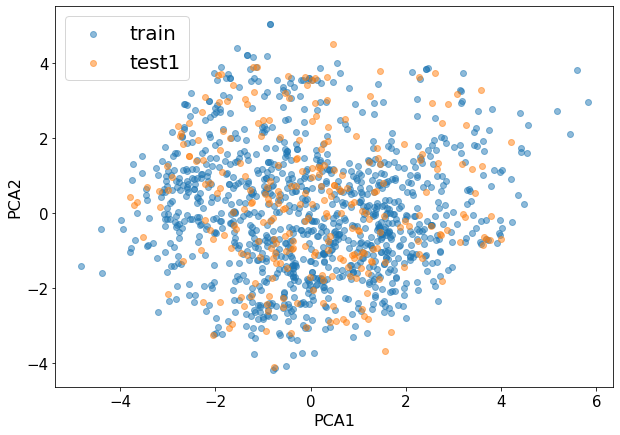

In [1395]:
plt.figure(figsize=(10,7))

font2 = {'family' : 'Times New Roman',
'weight' : 'bold',
'size' : 45,
}
plt.scatter(newX1[:, 0], newX1[:, 1], alpha=.5, label='train')
plt.scatter(newX2[:, 0], newX2[:, 1], alpha=.5, label='test1')
#plt.scatter(newX3[:, 0], newX3[:, 1], alpha=.5, label='test2')
plt.legend() 
plt.tick_params(labelsize=15)
plt.legend(prop={'family' : 'Times NewRoman', 'size'   : 20})
plt.xlabel('PCA1',fontsize=16)
plt.ylabel('PCA2',fontsize=16)
#plt.show()
#plt.savefig('domain2.jpg',dpi=300)